# Libraries installation

In [ ]:
!pip install autogluon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 18.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of openxlab to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of openxlab to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. 

In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118


Looking in indexes: https://download.pytorch.org/whl/cu118


In [ ]:
pip install lightgbm --config-settings=cmake.define.USE_GPU=ON

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import torch
print(torch.cuda.is_available())  # True si CUDA est disponible
print(torch.cuda.current_device())  # Affiche l'index du GPU (0 pour le premier GPU)
print(torch.cuda.get_device_name(0))  # Affiche le nom du GPU (par exemple, GTX 1060)


KeyboardInterrupt: 

# Data preprocessing

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
dfx = pd.read_csv('x_train_final.csv')
dfy=pd.read_csv('y_train_final_j5KGWWK.csv')
df_test=pd.read_csv('x_test_final.csv')

df_test=df_test.drop('Unnamed: 0', axis=1)
dfx=dfx.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1)
dfy=dfy.drop('Unnamed: 0', axis=1)

def preprocess1(df):
    # Convertir la colonne 'date' en format datetime si ce n'est pas déjà le cas
    df['date'] = pd.to_datetime(df['date'])

    # Extraire le mois et le jour dans de nouvelles colonnes
    df['mois'] = df['date'].dt.month
    df['jour'] = df['date'].dt.day
    df=df.drop('date', axis=1)
    # Retourner le DataFrame modifié
    return df

dfx=preprocess1(dfx)
df_test=preprocess1(df_test)
dfy['p0q0'] = dfy['p0q0'].astype(int)


dfy.describe()
def filter_dataframe(dfx, dfy):
    # Appliquer les conditions sur les colonnes de dfx
    filtered_dfx = dfx[
        (dfx['p2q0'] >= -32) & (dfx['p2q0'] <= 6) &
        (dfx['p3q0'] >= -31) & (dfx['p3q0'] <= 6) &
        (dfx['p4q0'] >= -46) & (dfx['p4q0'] <= 9) &
        (dfx['p0q2'] >= -46) & (dfx['p0q2'] <= 11) &
        (dfx['p0q3'] >= -66) & (dfx['p0q3'] <= 6) &
        (dfx['p0q4'] >= -57) & (dfx['p0q4'] <= 9)
    ]
    filtered_dfy = dfy.loc[filtered_dfx.index]
    filtered_dfy = filtered_dfy[(filtered_dfy['p0q0'] >= -66) & (filtered_dfy['p0q0'] <= 15)]
    filtered_dfx = filtered_dfx.loc[filtered_dfy.index]

    return filtered_dfx, filtered_dfy
# Appliquer la fonction de filtrage
dfx, dfy = filter_dataframe(dfx, dfy)



dfx= pd.concat([dfx, dfy['p0q0']], axis=1)


In [ ]:
from sklearn.preprocessing import StandardScaler

def normalize_and_center(train_df, test_df, exclude_col=None):
    """Normalise et centre toutes les variables numériques"""
    # Liste des colonnes numériques à normaliser
    numeric_cols = train_df.select_dtypes(include=np.number).columns.tolist()

    # Exclusion de la colonne cible si elle est présente
    if exclude_col and exclude_col in numeric_cols:
        numeric_cols.remove(exclude_col)

    # Création du scaler
    scaler = StandardScaler()

    # Application sur le train
    train_df[numeric_cols] = scaler.fit_transform(train_df[numeric_cols])

    # Application sur le test avec le même scaler
    test_df[numeric_cols] = scaler.transform(test_df[numeric_cols])

    return train_df, test_df

# Suppression de la colonne cible du dataframe de features
dfx = dfx.drop('p0q0', axis=1)

# Application de la normalisation
dfx, df_test = normalize_and_center(dfx, df_test)

# Réajout de la colonne cible au dataframe d'entraînement
dfx = pd.concat([dfx, dfy['p0q0']], axis=1)

In [ ]:


# Gares dans df_test mais pas dans dfx
valeurs_dans_test_pas_dans_dfx = set(dfx["gare"]) - set(df_test["gare"])
print("Valeurs présentes dans df_test mais pas dans dfx :", valeurs_dans_test_pas_dans_dfx)

# Gares dans dfx mais pas dans df_test
valeurs_dans_dfx_pas_dans_test = set(df_test["gare"]) - set(dfx["gare"])
print("Valeurs présentes dans dfx mais pas dans df_test :", valeurs_dans_dfx_pas_dans_test)

#Gares dans les 2
valeurs_dans_les_2 = set(df_test["gare"]) & set(dfx["gare"])
print("Gares dans les 2 :", valeurs_dans_les_2)




Valeurs présentes dans df_test mais pas dans dfx : {'TXR', 'BKS', 'OUA'}
Valeurs présentes dans dfx mais pas dans df_test : set()
Gares dans les 2 : {'ADU', 'QDF', 'ARX', 'RLW', 'AZA', 'JLR', 'WQT', 'NPF', 'CFK', 'WBF', 'QHI', 'RUP', 'PLR', 'HVA', 'DGG', 'ZHN', 'UAK', 'XJU', 'KOG', 'FFU', 'EAU', 'EOH', 'TRE', 'FDV', 'DCD', 'ZFB', 'PDG', 'GHU', 'IEG', 'OCA', 'JOD', 'NIJ', 'AVF', 'VXY', 'TXP', 'RSZ', 'AVU', 'YWQ', 'GDU', 'ZVY', 'RDU', 'QYY', 'LXX', 'VIS', 'TVD', 'YEG', 'XTD', 'OWI', 'MZE', 'OML', 'ELZ', 'WJF', 'XEH', 'GHQ', 'UPZ', 'ZAL', 'JEQ', 'OJA', 'KCK', 'LNI', 'NZC', 'AUW', 'KYF', 'RAN', 'BAP', 'JAQ', 'JUJ', 'MRI', 'JYH', 'WUP', 'OCB', 'PLF', 'KLN', 'GDN', 'JBZ', 'UYT', 'KDN', 'RDN', 'EME', 'WII', 'XIL'}


In [ ]:
# prompt: Fais un code qui supprime les gares "OUA", "TXR",  "BKS" de dfx

# Supprimer les gares spécifiées de dfx
gares_a_supprimer = ["OUA", "TXR", "BKS"]
dfx = dfx[~dfx['gare'].isin(gares_a_supprimer)]


# Model training

In [ ]:
import ray
ray.shutdown()
ray.init(num_cpus=107)

2025-02-05 22:29:54,581	INFO worker.py:1810 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Python version:,3.11.11
Ray version:,2.39.0
Dashboard:,http://127.0.0.1:8265


In [ ]:
train_df = dfx

# Modèle 1 : MAE=0.65

In [ ]:
import logging
from autogluon.tabular import TabularPredictor

# Configuration du logging pour suivre les étapes
logging.basicConfig(level=logging.INFO)

# Configuration du prédicteur
predictor = TabularPredictor(
    label='p0q0',  # Nom de la colonne cible
    eval_metric='f1_weighted',  # Optimisation pour un problème déséquilibré multiclasses
    problem_type='multiclass'  # Spécifiez le type de problème
)

# Entraînement avec plusieurs optimisations
predictor.fit(
    train_data=train_df,  # Données d'entraînement
    time_limit=3600 * 3,  # Limite de 5 heures pour l'entraînement
    presets='best_quality',  # Priorise la qualité des modèles au lieu de la vitesse
    num_stack_levels=1,  # Active un niveau d'empilement pour combiner plusieurs modèles
    num_bag_folds=5,  # Cross-validation avec 5 folds pour plus de robustesse
    hyperparameters={
        'FASTAI': {
            'device': 'cuda',  # Utilisation du GPU
            'epochs': 100,  # Augmentez les époques d'entraînement
            'early_stopping': 10,  # Arrêt anticipé après 10 époques sans amélioration

        },
    }
)

# Affiche un message pour indiquer la fin de l'entraînement
print("Entraînement terminé avec succès.")


ModuleNotFoundError: No module named 'autogluon'

# Modèle 2


In [ ]:
pip install catboost

In [ ]:
!pip install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 67.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.1/204.1 MB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 MB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!rm -r /content/AutogluonModels

In [ ]:
!pip install dask[dataframe]

INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 7.2 MB/s eta 0:00:00


In [ ]:
import logging
import numpy as np
import pandas as pd
from autogluon.tabular import TabularPredictor
from google.colab import files
import shutil

# Configuration du logging
logging.basicConfig(level=logging.INFO)

# Configuration pour la classification
predictor = TabularPredictor(
    label='p0q0',
    problem_type='multiclass',  # Classification multi-classes
    eval_metric='log_loss'  # Log loss est adapté à la classification
)

# Hyperparamètres optimisés pour la classification
hyperparameters = {
    'CAT': {
        'iterations': 3000,
        'learning_rate': 0.02,
        'depth': 10,
        'loss_function': 'MultiClass',
    },
    'FASTAI': {
        'layers': [1024, 512, 256],
        'early_stopping': 20,
        'metrics': ['accuracy'],
        'ps': 0.3,
    },
    'GBM': {
        'num_leaves': 60,
        'learning_rate': 0.01,
        'feature_fraction': 0.8,
    },
    'RF': {},
    'XT': {}
}

# Entraînement avec amélioration pour classification
predictor.fit(
    train_data=train_df,
    time_limit=3600 * 6,
    presets='best_quality',
    hyperparameters=hyperparameters,
    num_bag_folds=10,
    num_stack_levels=3,
)

# Sauvegarde et compression du modèle
model_path = "./AutogluonModels"
shutil.make_archive(model_path, 'zip', model_path)  # Compression du modèle
print(f"Modèle compressé en {model_path}.zip")

# Téléchargement du fichier ZIP
files.download(model_path + ".zip")


No path specified. Models will be saved in: "AutogluonModels/ag-20250205_223030"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Memory Avail:       10.31 GB / 12.67 GB (81.4%)
Disk Space Avail:   73.70 GB / 107.72 GB (68.4%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=3, num_bag_folds=10, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be 

(raylet) WARNING: 8 PYTHON worker processes have been started on node: 54ee93cfb50c6928a739930a9b493559af6694ae6f5014672bd60baa with address: 172.28.0.12. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).


(_dystack pid=5073) 	Time limit exceeded... Skipping NeuralNetFastAI_BAG_L1.
(_dystack pid=5073) Fitting model: LightGBM_BAG_L1 ... Training model for up to 1678.97s of the 5275.44s of remaining time.
(_dystack pid=5073) 	Memory not enough to fit 10 folds in parallel. Will train 4 folds in parallel instead (Estimated 13.14% memory usage per fold, 52.55%/80.00% total).
(_dystack pid=5073) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (2 workers, per: cpus=1, gpus=0, memory=13.14%)
(_ray_fit pid=6813) 	Warning: Not enough memory to safely train model. Estimated to require 1.130 GB out of 0.857 GB available memory (131.890%)... (90.000% of avail memory is the max safe size)
(_ray_fit pid=6813) 	To force training the model, specify the model hyperparameter "ag.max_memory_usage_ratio" to a larger value (currently 1.0, set to >=1.52 to avoid the error)
(_ray_fit pid=6813) 		To set the same value for all models, do the following when calling predictor

(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: 3684f6afb0954f4f801737412be499bbe791d440ffffffff Worker ID: 511920a7cfd7e041041810861875c5633230d408e98422832c279bde Node ID: 54ee93cfb50c6928a739930a9b493559af6694ae6f5014672bd60baa Worker IP address: 172.28.0.12 Worker port: 38245 Worker PID: 7399 Worker exit type: SYSTEM_ERROR Worker exit detail: The leased worker has unrecoverable failure. Worker is requested to be destroyed when it is returned. RPC Error message: Socket closed; RPC Error details: 
(raylet) WARNING: 12 PYTHON worker processes have been started on node: 54ee93cfb50c6928a739930a9b493559af6694ae6f5014672bd60baa with address: 172.28.0.12. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds). [repeated 2x across cluster] 

(raylet) 
(raylet) [2025-02-05 22:35:54,514 E 4991 4991] (raylet) node_manager.cc:3069: 5 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 54ee93cfb50c6928a739930a9b493559af6694ae6f5014672bd60baa, IP: 172.28.0.12) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 172.28.0.12`
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.


(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: 5e2c6380523976d0d4f31a2b6074de1344ed86d9ffffffff Worker ID: 37c35d7131ef4aa8e29f6f912364d60b75fd216525ea7ae2e67efbb7 Node ID: 54ee93cfb50c6928a739930a9b493559af6694ae6f5014672bd60baa Worker IP address: 172.28.0.12 Worker port: 43357 Worker PID: 7392 Worker exit type: SYSTEM_ERROR Worker exit detail: The leased worker has unrecoverable failure. Worker is requested to be destroyed when it is returned. RPC Error message: Socket closed; RPC Error details: 


(_ray_fit pid=8019) 	Warning: Not enough memory to safely train model. Estimated to require 1.195 GB out of 0.818 GB available memory (146.063%)... (100.000% of avail memory is the max safe size)
(_ray_fit pid=8019) 	To force training the model, specify the model hyperparameter "ag.max_memory_usage_ratio" to a larger value (currently 1.0, set to >=1.51 to avoid the error)
(_ray_fit pid=8019) 		To set the same value for all models, do the following when calling predictor.fit: `predictor.fit(..., ag_args_fit={"ag.max_memory_usage_ratio": VALUE})`
(_ray_fit pid=8019) 		Setting "ag.max_memory_usage_ratio" to values above 1 may result in out-of-memory errors. You may consider using a machine with more memory as a safer alternative.
(_dystack pid=5073) Consider decreasing folds trained in parallel by passing num_folds_parallel to ag_args_ensemble when calling `predictor.fit`.
(_dystack pid=5073) 	Not enough memory to train CatBoost_BAG_L1... Skipping this model.
(_dystack pid=5073) Fitting m

(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: a53d0f52d24241997f4b43d3e34ee56190cfe9af01000000 Worker ID: 90e33d6264147e611819c8f44bc40cfcb80cf5b1ac5413a8ea29c61e Node ID: 54ee93cfb50c6928a739930a9b493559af6694ae6f5014672bd60baa Worker IP address: 172.28.0.12 Worker port: 34373 Worker PID: 10684 Worker exit type: SYSTEM_ERROR Worker exit detail: Worker unexpectedly exits with a connection error code 2. End of file. There are some potential root causes. (1) The process is killed by SIGKILL by OOM killer due to high memory usage. (2) ray stop --force is called. (3) The worker is crashed unexpectedly due to SIGSEGV or other unexpected errors.
(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: a851c4e95f3399e5ab9d4386de5c418b978f166901000000 Worker ID: 7d

Consider decreasing folds trained in parallel by passing num_folds_parallel to ag_args_ensemble when calling `predictor.fit`.
	Not enough memory to train CatBoost_BAG_L1... Skipping this model.
Fitting model: ExtraTrees_BAG_L1 ... Training model for up to 6742.74s of the 20900.77s of remaining time.
	To force training the model, specify the model hyperparameter "ag.max_memory_usage_ratio" to a larger value (currently 1.0, set to >=10.44 to avoid the error)
		To set the same value for all models, do the following when calling predictor.fit: `predictor.fit(..., ag_args_fit={"ag.max_memory_usage_ratio": VALUE})`
		Setting "ag.max_memory_usage_ratio" to values above 1 may result in out-of-memory errors. You may consider using a machine with more memory as a safer alternative.
	Not enough memory to train ExtraTrees_BAG_L1... Skipping this model.
No base models to train on, skipping auxiliary stack level 2...
2025-02-05 22:42:11,657	ERROR worker.py:422 -- Unhandled error (suppress with 'RAY_

RuntimeError: No models were trained successfully during fit(). Inspect the log output or increase verbosity to determine why no models were fit. Alternatively, set `raise_on_no_models_fitted` to False during the fit call.

In [ ]:
from autogluon.tabular import TabularPredictor

# Post-processing
def postprocess(preds):
    return np.round(np.clip(preds, a_min=0, a_max=None)).astype(int)

predictor = TabularPredictor.load("/content/AutogluonModels/ag-20250205_083610")
test_pred = postprocess(predictor.predict(df_test))


In [ ]:
test_pred=pd.DataFrame(test_pred)
test_pred = pd.DataFrame({
    'Unnamed: 0': df_test.index,  # Utilisation des indices de X_test comme identifiants
    'p0q0': test_pred['p0q0']  # Ajouter les prédictions dans la colonne p0q0
})
test_pred.to_csv('nouveau.csv', index=False)

In [ ]:
from autogluon.tabular import TabularPredictor


preds=predictor.predict(df_test)
preds=pd.DataFrame(preds)
predictions_df = pd.DataFrame({
    'Unnamed: 0': df_test.index,  # Utilisation des indices de X_test comme identifiants
    'p0q0': preds['p0q0']  # Ajouter les prédictions dans la colonne p0q0
})
predictions_df.to_csv('predictions_final3.csv', index=False)

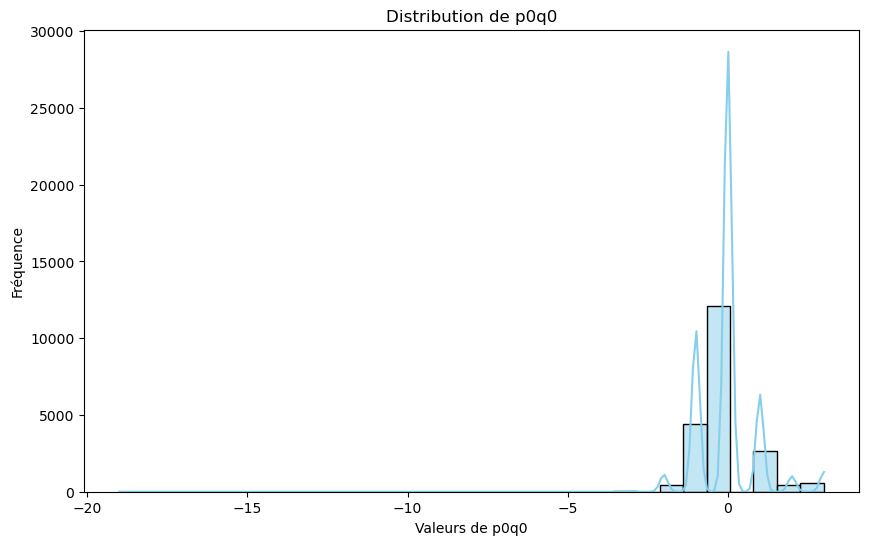

In [ ]:
# Tracer la distribution
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.histplot(predictions_df['p0q0'], kde=True, bins=30, color='skyblue')

# Ajouter des titres et des labels
plt.title('Distribution de p0q0')
plt.xlabel('Valeurs de p0q0')
plt.ylabel('Fréquence')

# Afficher le graphique
plt.show()


In [ ]:
import csv
#Prendre les arrondis de chaque valeur
predictions_df['p0q0'] = round(predictions_df["p0q0"])
predictions_df.to_csv('predictions_arrondi.csv',index=False)